In [22]:
import tensorflow as tf
import argparse
import json
import string
import os
import shutil
import uuid
from captcha.image import ImageCaptcha
import itertools
import os
import cv2
import numpy as np
from random import random, randint, choices
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input
import matplotlib.pyplot as plt

In [23]:
# generated CAPTCHAs using Python ImageCaptcha Library
alphabet_all = list('qwertyuiopasdfghjklzxcvbnm0123456789QWERTYUIOPLKJHGFDSAZXCVBNM')
alphabet = list('qwertyuiopasdfghjklzxcvbnm0123456789')#QWERTYUIOPLKJHGFDSAZXCVBNM')
num_alphabet = len(alphabet)

def _gen_captcha(img_dir, num_of_letters, num_of_repetition, width, height):
    if os.path.exists(img_dir):
        shutil.rmtree(img_dir)
    if not os.path.exists(img_dir):
        os.makedirs(img_dir)
        
    image = ImageCaptcha(width=width, height=height)

    for counter in range(num_of_repetition):
        i = choices(alphabet_all, k=5)
        captcha = ''.join(i)
        fn = os.path.join(img_dir, '%s_%s.png' % (captcha, uuid.uuid4()))
        image.write(captcha, fn)

def gen_dataset(path, num_of_repetition, num_of_letters, width, height):
    _gen_captcha(os.path.join(path, 'data'), num_of_letters, num_of_repetition, width, height)
    print('Finished Data Generation')

In [24]:
BATCH_SIZE = 128
NUM_OF_LETTERS = 5
EPOCHS = 50
IMG_ROW, IMG_COLS = 50, 135
# Non-configs
PATH = os.getcwd() # get current path
DATA_PATH = os.path.join(PATH, 'train')# create new folder for data

In [25]:
#pre-processing
def load_data(path, test_split=0.1):
    print ('loading dataset...')
    y_train = []
    y_test = []
    x_train = []
    x_test = []

    # r=root, d=directories, f = files
    counter = 0
    for r, d, f in os.walk(path):
        for fl in f:
            if '.png' in fl:
                flr = fl.split('_')[0]
                counter += 1
                label = np.zeros((NUM_OF_LETTERS, num_alphabet))
                for i in range(NUM_OF_LETTERS):
                    label[i, alphabet.index(flr[i].lower())] = 1
#                 label = np.zeros((50, 1))
#                 for i in range(5):
#                     label[i*5+int(flr[i])] = 1
                img = cv2.imread(os.path.join(r, fl))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = cv2.resize(img, (int(135/2), int(50/2)), interpolation=cv2.INTER_AREA)
                img = np.reshape(img, (img.shape[0], img.shape[1], 1))

                if random() < test_split:
                    y_test.append(label)
                    x_test.append(img)
                else:
                    y_train.append(label)
                    x_train.append(img)

    print('dataset size:', counter, '(train=%d, test=%d)' % (len(y_train), len(y_test)))
    return np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)

In [26]:
if not os.path.exists(DATA_PATH):
    print('Generating Dataset')
    gen_dataset(DATA_PATH, 10000 , NUM_OF_LETTERS, IMG_COLS, IMG_ROW)

In [27]:
x_train, y_train, x_test, y_test = load_data(DATA_PATH)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

loading dataset...
dataset size: 10000 (train=9023, test=977)


In [28]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(9023, 25, 67, 1)
(9023, 5, 36)
(977, 25, 67, 1)
(977, 5, 36)


In [29]:
s_train = []
s_test = []
for i in range(NUM_OF_LETTERS):
    s_train.append(y_train[:, i, :])
    s_test.append(y_test[:, i, :])

In [30]:
save_dir = os.path.join(PATH, 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

In [31]:
#architecture
input_layer = Input((25, 67, 1))
x = Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation='relu')(input_layer)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(filters=48, kernel_size=(5, 5), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(filters=64, kernel_size=(5, 5), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Dropout(0.3)(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)

out = [Dense(num_alphabet, name='digit%d' % i, activation='softmax')(x) for i in range(NUM_OF_LETTERS)]
# out = Dense(num_alphabet*5, activation='sigmoid')(x)

model = Model(inputs=input_layer, outputs=out)

In [32]:
# model_path = os.path.join(save_dir, model_name)
# model = keras.models.load_model(model_path)

In [33]:
# initiate Adam optimizer

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


model.summary() 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 25, 67, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 25, 67, 32)   832         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 12, 33, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 12, 33, 48)   38448       max_pooling2d[0][0]              
______________________________________________________________________________________________

In [34]:
hist_train_loss_digit = {i:[] for i in range(5)}
hist_test_loss_digit = {i:[] for i in range(5)}

hist_train_acc_digit = {i:[] for i in range(5)}
hist_test_acc_digit = {i:[] for i in range(5)}

hist_train_loss = []
hist_test_loss = []

hist_train_acc = []
hist_test_acc = []

In [35]:
digit_acc = [[] for _ in range(NUM_OF_LETTERS)]
val_digit_acc = [[] for _ in range(NUM_OF_LETTERS)]
loss = []
val_loss = []

In [36]:
history = model.fit(x_train, s_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    verbose=1,
                    validation_data=(x_test, s_test)
                   )

Train on 9023 samples, validate on 977 samples
Epoch 1/50
9023/9023 [==============================] - 28s 3ms/sample - loss: 0.6310 - digit0_loss: 0.1263 - digit1_loss: 0.1262 - digit2_loss: 0.1262 - digit3_loss: 0.1262 - digit4_loss: 0.1261 - digit0_accuracy: 0.9722 - digit1_accuracy: 0.9722 - digit2_accuracy: 0.9722 - digit3_accuracy: 0.9722 - digit4_accuracy: 0.9722 - val_loss: 0.6286 - val_digit0_loss: 0.1257 - val_digit1_loss: 0.1258 - val_digit2_loss: 0.1256 - val_digit3_loss: 0.1259 - val_digit4_loss: 0.1256 - val_digit0_accuracy: 0.9722 - val_digit1_accuracy: 0.9722 - val_digit2_accuracy: 0.9722 - val_digit3_accuracy: 0.9722 - val_digit4_accuracy: 0.9722
Epoch 2/50
9023/9023 [==============================] - 23s 3ms/sample - loss: 0.6296 - digit0_loss: 0.1260 - digit1_loss: 0.1260 - digit2_loss: 0.1260 - digit3_loss: 0.1258 - digit4_loss: 0.1258 - digit0_accuracy: 0.9722 - digit1_accuracy: 0.9722 - digit2_accuracy: 0.9722 - digit3_accuracy: 0.9722 - digit4_accuracy: 0.9722 - 

9023/9023 [==============================] - 21s 2ms/sample - loss: 0.4100 - digit0_loss: 0.0662 - digit1_loss: 0.0928 - digit2_loss: 0.0964 - digit3_loss: 0.0903 - digit4_loss: 0.0644 - digit0_accuracy: 0.9776 - digit1_accuracy: 0.9731 - digit2_accuracy: 0.9729 - digit3_accuracy: 0.9736 - digit4_accuracy: 0.9781 - val_loss: 0.4040 - val_digit0_loss: 0.0636 - val_digit1_loss: 0.0921 - val_digit2_loss: 0.0947 - val_digit3_loss: 0.0888 - val_digit4_loss: 0.0650 - val_digit0_accuracy: 0.9779 - val_digit1_accuracy: 0.9732 - val_digit2_accuracy: 0.9728 - val_digit3_accuracy: 0.9734 - val_digit4_accuracy: 0.9774
Epoch 15/50
9023/9023 [==============================] - 22s 2ms/sample - loss: 0.3922 - digit0_loss: 0.0626 - digit1_loss: 0.0888 - digit2_loss: 0.0936 - digit3_loss: 0.0868 - digit4_loss: 0.0604 - digit0_accuracy: 0.9785 - digit1_accuracy: 0.9737 - digit2_accuracy: 0.9733 - digit3_accuracy: 0.9740 - digit4_accuracy: 0.9789 - val_loss: 0.3922 - val_digit0_loss: 0.0604 - val_digit1_l

9023/9023 [==============================] - 22s 2ms/sample - loss: 0.2687 - digit0_loss: 0.0383 - digit1_loss: 0.0641 - digit2_loss: 0.0691 - digit3_loss: 0.0605 - digit4_loss: 0.0366 - digit0_accuracy: 0.9863 - digit1_accuracy: 0.9790 - digit2_accuracy: 0.9778 - digit3_accuracy: 0.9799 - digit4_accuracy: 0.9868 - val_loss: 0.3341 - val_digit0_loss: 0.0471 - val_digit1_loss: 0.0795 - val_digit2_loss: 0.0829 - val_digit3_loss: 0.0750 - val_digit4_loss: 0.0497 - val_digit0_accuracy: 0.9828 - val_digit1_accuracy: 0.9761 - val_digit2_accuracy: 0.9748 - val_digit3_accuracy: 0.9760 - val_digit4_accuracy: 0.9817
Epoch 28/50
9023/9023 [==============================] - 21s 2ms/sample - loss: 0.2632 - digit0_loss: 0.0376 - digit1_loss: 0.0630 - digit2_loss: 0.0681 - digit3_loss: 0.0597 - digit4_loss: 0.0349 - digit0_accuracy: 0.9864 - digit1_accuracy: 0.9792 - digit2_accuracy: 0.9780 - digit3_accuracy: 0.9800 - digit4_accuracy: 0.9874 - val_loss: 0.3330 - val_digit0_loss: 0.0463 - val_digit1_l

9023/9023 [==============================] - 22s 2ms/sample - loss: 0.2031 - digit0_loss: 0.0280 - digit1_loss: 0.0491 - digit2_loss: 0.0538 - digit3_loss: 0.0463 - digit4_loss: 0.0259 - digit0_accuracy: 0.9900 - digit1_accuracy: 0.9832 - digit2_accuracy: 0.9816 - digit3_accuracy: 0.9839 - digit4_accuracy: 0.9905 - val_loss: 0.3277 - val_digit0_loss: 0.0469 - val_digit1_loss: 0.0783 - val_digit2_loss: 0.0821 - val_digit3_loss: 0.0729 - val_digit4_loss: 0.0480 - val_digit0_accuracy: 0.9834 - val_digit1_accuracy: 0.9757 - val_digit2_accuracy: 0.9748 - val_digit3_accuracy: 0.9766 - val_digit4_accuracy: 0.9828
Epoch 41/50
9023/9023 [==============================] - 22s 2ms/sample - loss: 0.2018 - digit0_loss: 0.0279 - digit1_loss: 0.0489 - digit2_loss: 0.0528 - digit3_loss: 0.0457 - digit4_loss: 0.0266 - digit0_accuracy: 0.9898 - digit1_accuracy: 0.9830 - digit2_accuracy: 0.9819 - digit3_accuracy: 0.9841 - digit4_accuracy: 0.9902 - val_loss: 0.3270 - val_digit0_loss: 0.0448 - val_digit1_l

In [38]:
digit_acc = [[] for _ in range(NUM_OF_LETTERS)]
val_digit_acc = [[] for _ in range(NUM_OF_LETTERS)]
loss = []
val_loss = []


def plot_diagram(digit_acc_now, val_digit_acc_now, loss_now, val_loss_now):
    global digit_acc, val_digit_acc, loss, val_loss
    
    
    for i in range(NUM_OF_LETTERS):
        digit_acc[i].extend(digit_acc_now[i])
        val_digit_acc[i].extend(val_digit_acc_now[i])
    loss.extend(loss_now)
    val_loss.extend(val_loss_now)
    
    for i in range(NUM_OF_LETTERS):
        s = {0:'First', 1:'Second', 2:'Third', 3:'Fourth', 4:'Fifth'}[i]
        # plt.plot(val_digit_acc[i], label='%s Digit Train' % s)
        plt.plot(digit_acc[i], label='%s Digit Test' % s)

    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    for i in range(NUM_OF_LETTERS):
        s = {0:'First', 1:'Second', 2:'Third', 3:'Fourth', 4:'Fifth'}[i]
        plt.plot(val_digit_acc[i], label='%s Digit Train' % s)
        # plt.plot(digit_acc[i], label='%s Digit Test' % s)

    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    # Plot training & validation loss values
    
    plt.plot(val_loss, label='Train')
    plt.plot(loss, label='Test')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

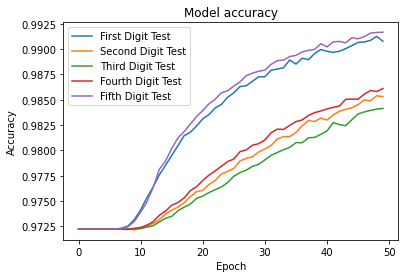

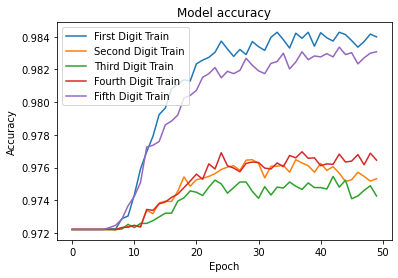

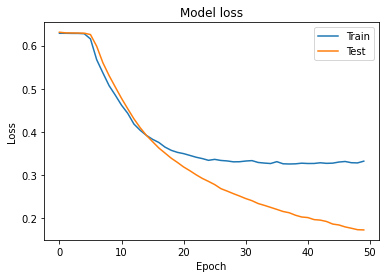

In [39]:
plot_diagram(
    
    [history.history['digit%d_accuracy' % i] for i in range(NUM_OF_LETTERS)],
    [history.history['val_digit%d_accuracy' % i] for i in range(NUM_OF_LETTERS)],
    history.history['loss'],
    history.history['val_loss'],
)

In [20]:
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /Users/dong/Desktop/HH/Semester_3/PR/Captcha/saved_models/keras_cifar10_trained_model.h5 


In [40]:
# Score trained model.
scores = model.evaluate(x_train, s_train, verbose=1)
print('Train loss:     %f' % np.mean(scores[0:5]))
acc = 1.
for i in range(5):
    acc *= scores[6+i]
print('Train accuracy: %.2f' % (acc * 100.))


9023/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Train loss:     0.023677
Train accuracy: 98.44


In [22]:
scores = model.evaluate(x_test, s_test, verbose=1)
print('Test loss:     %f' % np.mean(scores[0:5]))
acc = 1.
for i in range(5):
    acc *= scores[6+i]
print('Test accuracy: %.2f' % (acc * 100.))

Train loss:     0.019138
Train accuracy: 98.84
1002/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Test loss:     0.105219
Test accuracy: 90.92


In [20]:
# from keras.models import load_model
# model=load_model("saved_models/keras_cifar10_trained_model.h5")

ImportError: cannot import name 'get_config' from 'tensorflow.python.eager.context' (/Users/dong/opt/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow_core/python/eager/context.py)

In [41]:
# test other captcha
img = cv2.imread('1a1SZ.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img, (int(135/2), int(50/2)), interpolation=cv2.INTER_AREA)
img = np.reshape(img, (img.shape[0], img.shape[1], 1))
